By Danilo Aballay, Federico Fuentes, Vicente Iligaray, Ángel J. Omella, David Pardo, Manuel A. Sánchez, Ignacio Tapia, Carlos Uriarte

This notebook is used for the arctangent sigmoid

$$ u = \arctan(\alpha (x - s) ) + \arctan(\alpha  s)$$

With $\alpha = 10$ and $s = 0.5$

In [1]:
# Import libraries
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from scipy.integrate import quad

os.environ["KERAS_BACKEND"] = "jax"

import keras

from fem_system import solve, solve_and_loss
from r_adaptivity_NN import make_model, make_loss_model, lr_schedule, tricky_loss
from Problem import Problem

# Set the random seed
np.random.seed(1234)
keras.utils.set_random_seed(1234)
jax.config.update('jax_default_device', jax.devices('cpu')[0])

dtype='float64' # double precision set to default in the SCR functions
jax.config.update("jax_enable_x64", True)
keras.backend.set_floatx(dtype)

2025-06-10 17:03:23.800132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-10 17:03:23.816963: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-10 17:03:23.822422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def Exact_Ritz():
    problem = Problem()
    alpha = problem.alpha
    s     = problem.s
    eval_r = lambda x: 0.5* alpha * ((alpha * (-s + x))/(1 + alpha**2 * (s - x)**2) - np.arctan(alpha* (s - x)))
    return - 0.5 * (eval_r(1)- eval_r(0))

In [3]:
# Create the model
# Number of elements
N = 32
# Number of neurons 
nn = N
# Number of training iterations
iterations = 3000

# Initialize the neural network model for the approximate solution
model = make_model(nn)
# Save initial nodes
init_nodes = model(jnp.array([1]))
# Create loss model
loss_model = make_loss_model(model)
# Optimizer (Adam optimizer with a specific learning rate)
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
# Learning rate schedule
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
# Compile the loss model with a custom loss function (tricky_loss)
loss_model.compile(optimizer=optimizer, loss=tricky_loss)

In [4]:
# Train the model
start_time = time.time()
history    = loss_model.fit(jnp.array([1.]), jnp.array([1.]), epochs=iterations, callbacks = [lr_scheduler], verbose=1)
end_time   = time.time() 
print('Training time: ', end_time - start_time)

Epoch 1/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step - loss: -7.7969 - learning_rate: 0.0100
Epoch 2/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - loss: -7.7977 - learning_rate: 0.0100
Epoch 3/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -7.7984 - learning_rate: 0.0100
Epoch 4/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -7.7991 - learning_rate: 0.0100
Epoch 5/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -7.7997 - learning_rate: 0.0100
Epoch 6/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -7.8004 - learning_rate: 0.0100
Epoch 7/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -7.8010 - learning_rate: 0.0100
Epoch 8/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -7.8016 - learning_rate: 0.0100
Epoch 9/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -7.8022 - learning_rate: 0.0100
Epoch 10/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -7.8027 - learning_rate: 0.0100
Epoch 11/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -7.8032 - learning_rate: 0.0100
Epoc

e_h: 0.06356513274120873
e_theta: 0.03540787113227258


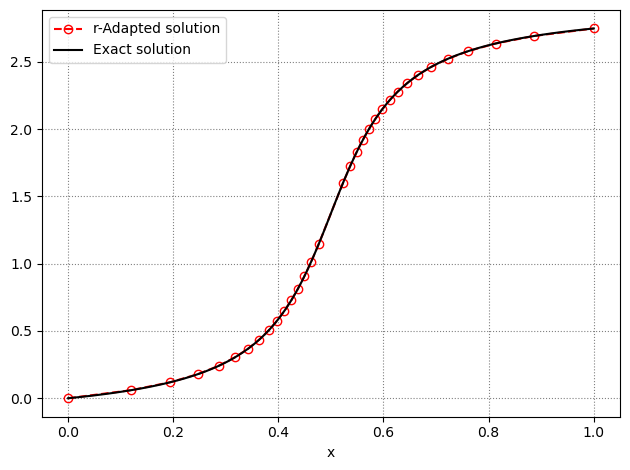

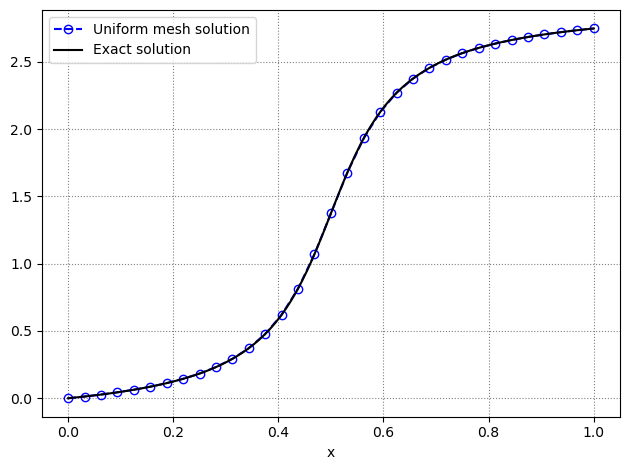

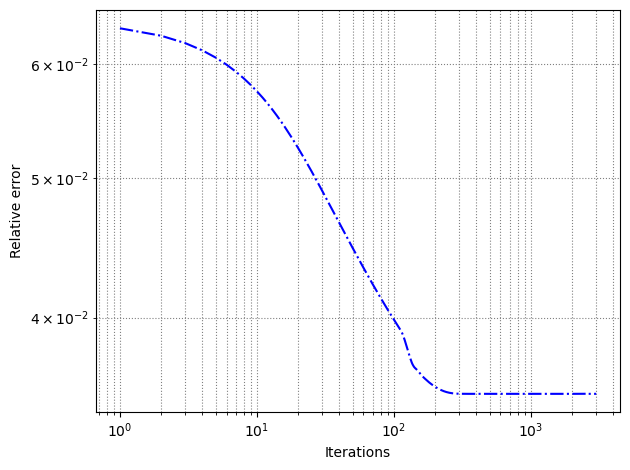

In [6]:
# Plot results
uniform_nodes = jnp.linspace(0, 1, nn+1)

node_coords, u = solve(model(jnp.array([1])))
uniform_coords, o = solve(uniform_nodes)
x = np.linspace(0, 1, 100)
y = np.arctan(10*(x-0.5)) + np.arctan(10*0.5)

J_u_theta = np.array(history.history['loss'])
J_u       = Exact_Ritz()
J_u_h = solve_and_loss(uniform_nodes)
rel_error_theta = np.sqrt((J_u - J_u_theta)/J_u)
rel_error_h = np.sqrt((J_u - J_u_h)/J_u)
print('e_h:', rel_error_h)
print('e_theta:', rel_error_theta[-1])

# Plot the approximate solution obtained from the trained model
plt.figure(1)
plt.plot(node_coords, u,'o--', color='r', fillstyle='none')
plt.plot(x, y, color='k')
plt.xlabel('x')
plt.legend(['r-Adapted solution', 'Exact solution'])
plt.grid(which = 'both', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()

# Plot the approximate solution obtained from the uniform mesh
plt.figure(2)
plt.plot(uniform_coords, o, 'o--', color='b', fillstyle='none')
plt.plot(x, y, color='k')
plt.xlabel('x')
plt.legend(['Uniform mesh solution', 'Exact solution'])
plt.grid(which = 'both', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()

# Plot the relative error
plt.figure(3)
plt.loglog(np.arange(1,iterations+1), rel_error_theta,'-.', color='b')
plt.xlabel('Iterations')
plt.ylabel('Relative error')
plt.grid(which = 'both', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()

plt.show()